# Visualizing Dirichlet with 3 Parameters

Based on
http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/

with extensions

# Making a mesh grid of n polygon

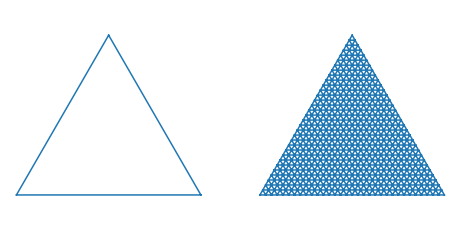

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri


def polygon_mesh(s=4, n=3, r=1):
    """
    Paramters:
        * s: subdivision depth
        * n: number of sides of the polygon
        * r: radius of the polygon, i.e. distance between 
             center of the polygon to one of the verticies
       
    Return:
        * vertices: vertices of the polygon
        * triangle: triangulated version of the polygon 
            (matplotlib.tri.triangulation.Triangulation)
        * trimesh: triangle mesh version of the polygon
            (matplotlib.tri.triangulation.Triangulation)
    """
    vertices = np.c_[r * np.cos(2 * np.pi * np.arange(1, n+1) / n  - (np.pi/2-np.pi/n)), 
                     r * np.sin(2 * np.pi * np.arange(1, n+1) / n  - (np.pi/2-np.pi/n))]
    if n>3: # add the center to triangulation
        vertices = np.vstack([vertices, vertices.mean(axis=0)])

    triangle = tri.Triangulation(vertices[:, 0], vertices[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=s if n>3 else s+1)
    
    return vertices, triangle, trimesh

vertices, triangle, trimesh = polygon_mesh(s=4, n=3, r=1)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

# Converting to Barycenter coordinates

In [65]:
def barycentric_coordinates_simplex(vertices, points):
    """
    Use the relationship:
                      [[x1, y1, 1],     
      [λ1, λ2, λ3] *   [x2, y2, 1],  = [X, Y, 1]
                       [x3, y3, 1]]
                       
    where 
    λ are Barycentric coorinates, 
    x1, y1, ... etc. are vertices, and 
    X, Y are Cartesian points
    
    This function can solve multi-dimensional simplex barycentric coordinates.
    """
    # Make the vertice matrix
    T = np.hstack([vertices, np.ones((3, 1))])
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    P = np.hstack([points, np.ones((points.shape[0], 1))])
    Lambdas = np.matmul(P, np.linalg.inv(T))
    if points.shape[0]<2:
        Lambdas = Lambdas[0]
    return Lambdas    


def barycentric_coordinates_simplex2(vertices, points):
    """
    Use the relationship:
                [[x1-x3, y1-y3],     
      [λ1, λ2] * [x2-x3, y2-y3]] = [X-x3, Y-y3]
                       
       λ3 = 1 - λ1 - λ2
                       
    where 
    λ are Barycentric coorinates, 
    x1, y1, ... etc. are vertices, and 
    X, Y are Cartesian points
    
    This function can solve multi-dimensional simplex barycentric coordinates.
    """
    T = vertices[:-1, :] - vertices[-1:None, :]
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    P = points - vertices[-1:None, :]
    Lambdas = np.matmul(P, np.linalg.inv(T))
    # Calculate the last lambda
    Lambdas = np.hstack([Lambdas, 1-np.sum(Lambdas, axis=1, keepdims=True)])
    if points.shape[0]<2:
        Lambdas = Lambdas[0]
    return Lambdas
    

In [66]:
points = np.array([0.1, 0.2])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_simplex2(vertices, points))

[0.46666667 0.20893164 0.32440169]
[0.46666667 0.20893164 0.32440169]


# Calculate Dirichlet PDF

In [12]:
from scipy.special import gamma as gamma_func
def dirichlet_pdf(alpha, x):
    """
    alpha: array of Dirichlet alpha parameter
    x: array of the support of Dirichlet
    """
    alpha , x = np.array(alpha), np.array(x)
    assert alpha.shape[0] == x.shape[-1]
    coef = gamma_func(np.sum(alpha)) / np.prod(gamma_func(alpha))
    pdf = coef * np.prod(np.power(x, alpha-1), axis=1 if len(x.shape)>1 else None)
    return pdf

dirichlet_pdf([0.3, 0.5, 0.3], [0.2,0.4,0.4])

0.5556159521906762

# Make the plots

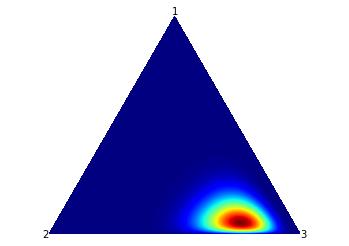

In [10]:
def plot_dirichlet_contour(alpha=np.array([1, 1, 1]), nlevels=200, resolution=8, cmap='jet', **kwargs):
    # Make the polygon
    vertices, _, trimesh = polygon_mesh(s=resolution, n=3, r=1)
    # Convert to Barycentric coordinates
    points = np.c_[trimesh.x, trimesh.y]
    shifts = np.min(vertices, axis=0)
    points = points - shifts
    vertices = vertices - shifts
    bary_coord = barycentric_coordinates_simplex(vertices, points)
    # Calculate Dirichlet pdf
    pvals = dirichlet_pdf(alpha, bary_coord)

    # Make the plot
    plt.tricontourf(trimesh, pvals, nlevels, cmap=cmap, **kwargs)
    plt.gca().text(vertices[0,0]+shifts[0], vertices[0, 1]+shifts[1], "1", ha='center', va='bottom')
    plt.gca().text(vertices[1,0]+shifts[0], vertices[1, 1]+shifts[1], "2", ha='right', va='center')
    plt.gca().text(vertices[2,0]+shifts[0], vertices[2, 1]+shifts[1], "3", ha='left', va='center')

    plt.axis('equal')
    plt.axis('off')
    
plot_dirichlet_contour([2, 5, 15])

# Barycentric Coordinates of N polygon

[Generalized Barycentric Coordinates on Irregular Polygons](http://www.geometry.caltech.edu/pubs/MHBD02.pdf)

In [116]:
def cotangent(a, b, c):
    """Compute cotagent of non-degenerate triangle abc at vertex b"""
    ba = a - b # m x 2 matrix
    bc = c - b # 1 x 2 vector
    return np.dot(ba, bc) / np.abs(np.cross(ba, bc)+1E-6) # 1 x m vector
    

def barycentric_coordinates_n_polygon(vertices, points):
    """
    Compute the barycentric weights for a set of points in an N polygon
    Assume all the points are strictly within the polygon 
    and the vertices are ordered
    
    For a single point "p", the algorithm is:
    
    cotangent = lambda a, b, c: np.dot(c-b, a-b) / np.sum((np.cross(c-b, a-b))**2)
    
    n = vertices.shape[0] # number of sides / vertices in the polygon
    w = np.empty(n)
    for j, q_j in enumerate(vertices):
        prev_index = (j+n-1) % n
        next_index = (j+1) % n
        w[j] = (cotangent(p, q_j, vertices[prev_index]) + \
                cotangent(p, q_j, vertices[next_index])) / \
                np.sum((p - q_j)**2)
        
    w = w / np.sum(w)
    
    return w
    """
    if len(points.shape) < 2:
        points = points[np.newaxis, :]
    n = vertices.shape[0] # number of sides / vertices in the polygon
    m = points.shape[0] # number of points
    w = np.empty((m, n)) # m points, n vertices
    for j, q_j in enumerate(vertices):
        prev_index = (j+n-1) % n
        next_index = (j+1) % n
        w[:, j] = (cotangent(points, q_j, vertices[prev_index]) + \
                   cotangent(points, q_j, vertices[next_index])) / \
                   np.sum((points - q_j)**2+1E-6, axis=1)
        
    # Normalize weights
    w = w / np.sum(w, axis=1, keepdims=True)
    
    if w.shape[0] < 2:
        w = w[0]
    
    return w

vertices, _, trimesh = polygon_mesh(s=4, n=3, r=1)
points = np.array([[0.3, 0.2], [0.1, 0.2]])
print(barycentric_coordinates_simplex(vertices, points))
print(barycentric_coordinates_n_polygon(vertices, points))

[[0.46666667 0.09346159 0.43987175]
 [0.46666667 0.20893164 0.32440169]]
[[0.46666494 0.09346172 0.43987335]
 [0.466666   0.20893176 0.32440224]]


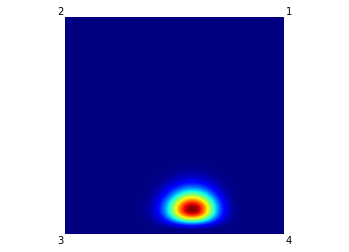

In [127]:
def plot_dirichlet_contour_n_poly(alpha=np.array([1, 1, 1]), nlevels=200, resolution=8, cmap='jet', **kwargs):
    # Make the polygon
    vertices, _, trimesh = polygon_mesh(s=resolution, n=len(alpha), r=1)
    if vertices.shape[0]>3: # for polygons greater than 3
        center, vertices = vertices[-1, :], vertices[:-1, :]
    else:
        center = np.mean(vertices, axis=0)
    # Convert to Barycentric coordinates
    points = np.c_[trimesh.x, trimesh.y]
    shifts = np.min(vertices, axis=0)
    points = points - shifts
    offsets = (vertices - center) * 0.05
    vertices = vertices - shifts
    bary_coord = barycentric_coordinates_n_polygon(vertices, points)
    #bary_coord[~np.isfinite(bary_coord)] = 0
    # Calculate Dirichlet pdf
    pvals = dirichlet_pdf(alpha, bary_coord)

    # Make the plot
    plt.tricontourf(trimesh, pvals, nlevels, cmap=cmap, **kwargs)
    
    # Label the vertices
    for i in range(vertices.shape[0]):
        plt.gca().text(vertices[i,0]+shifts[0]+offsets[i, 0], vertices[i, 1]+shifts[1]+offsets[i, 1], 
                       "{:d}".format(i+1), ha='center', va='center')
    
    plt.axis('equal')
    plt.axis('off')

alpha = np.array([2, 5, 15, 25])
plot_dirichlet_contour_n_poly(alpha)